<h1>LSTM Training v1</h1>

In [53]:
import pandas as pd

# Load the data
climate_data = pd.read_csv('dataset/transformed/combined_weather_data.csv')
device_data = pd.read_csv('dataset/transformed/may_device_resampled.csv')

# Convert 'time' columns to datetime format
climate_data['time'] = pd.to_datetime(climate_data['time'])
device_data['time'] = pd.to_datetime(device_data['time'])

# Set the 'time' column as the index for resampling
device_data.set_index('time', inplace=True)

# Resample device data to hourly frequency, using mean aggregation for numeric columns
device_data_resampled = device_data.resample('H').mean().reset_index()

# Merge datasets on the 'time' column
merged_data = pd.merge(climate_data, device_data_resampled, on='time', how='inner')

# Print column names
print("Merged Data Columns:")
print(merged_data.columns)


Merged Data Columns:
Index(['time', 'temperature', 'humidity', 'device_temperature'], dtype='object')


In [54]:
# Merge datasets on the 'time' column
merged_data = pd.merge(climate_data, device_data_resampled, on='time', how='inner')

# Display the first few rows of the merged dataset
merged_data.head()

,time,temperature,humidity,device_temperature
0,2023-05-15 15:00:00+08:00,32,0.59,20.235481
1,2023-05-15 16:00:00+08:00,29,0.70,20.294899
2,2023-05-15 17:00:00+08:00,29,0.70,20.349930
3,2023-05-15 18:00:00+08:00,30,0.70,20.362968
4,2023-05-15 19:00:00+08:00,29,0.74,20.321732


Epoch 1/100
10/10 [==============================] - 2s 42ms/step - loss: 551.7644 - mean_absolute_error: 23.3190 - val_loss: 534.4380 - val_mean_absolute_error: 22.9545
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 549.8521 - mean_absolute_error: 23.2786 - val_loss: 532.3715 - val_mean_absolute_error: 22.9104
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 547.4646 - mean_absolute_error: 23.2283 - val_loss: 529.6416 - val_mean_absolute_error: 22.8522
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 544.2439 - mean_absolute_error: 23.1608 - val_loss: 525.8326 - val_mean_absolute_error: 22.7710
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 539.3042 - mean_absolute_error: 23.0573 - val_loss: 520.3282 - val_mean_absolute_error: 22.6533
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 532.5087 - mean_absolute_error: 22.9147 - val_loss: 512.2088 - val_mean_absolute_

d:\Work\Capstone\Capstone-BMS-Project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 1.698090320246454
Mean Squared Error (MSE): 4.822833191858643
Root Mean Squared Error (RMSE): 2.1960949869845434
R² Score: 0.3620734623505979


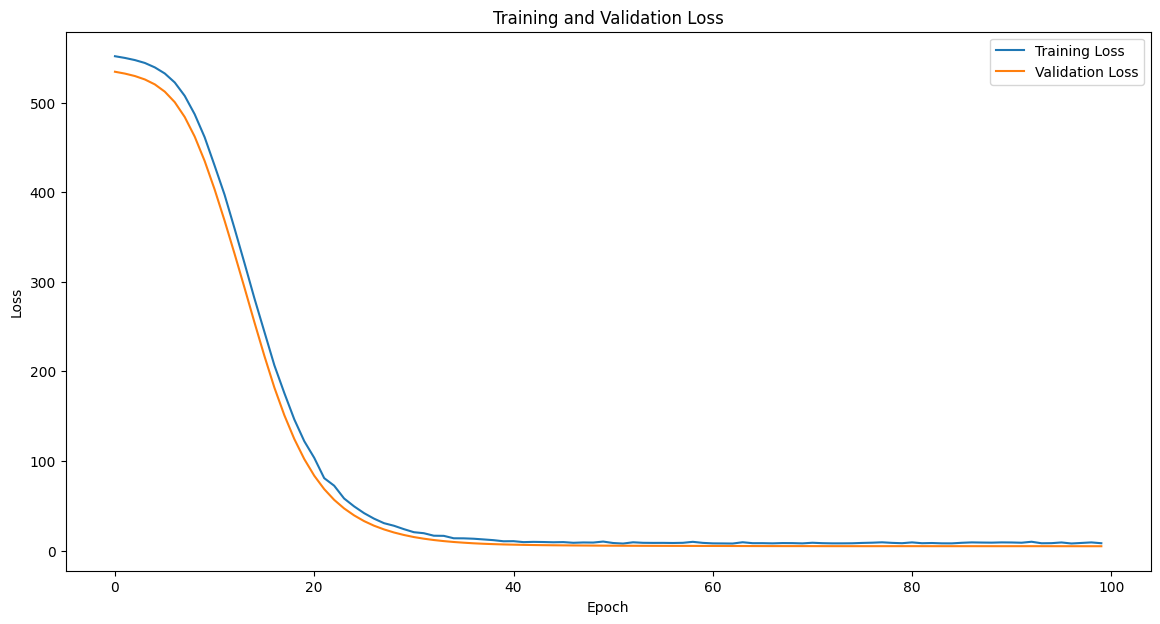

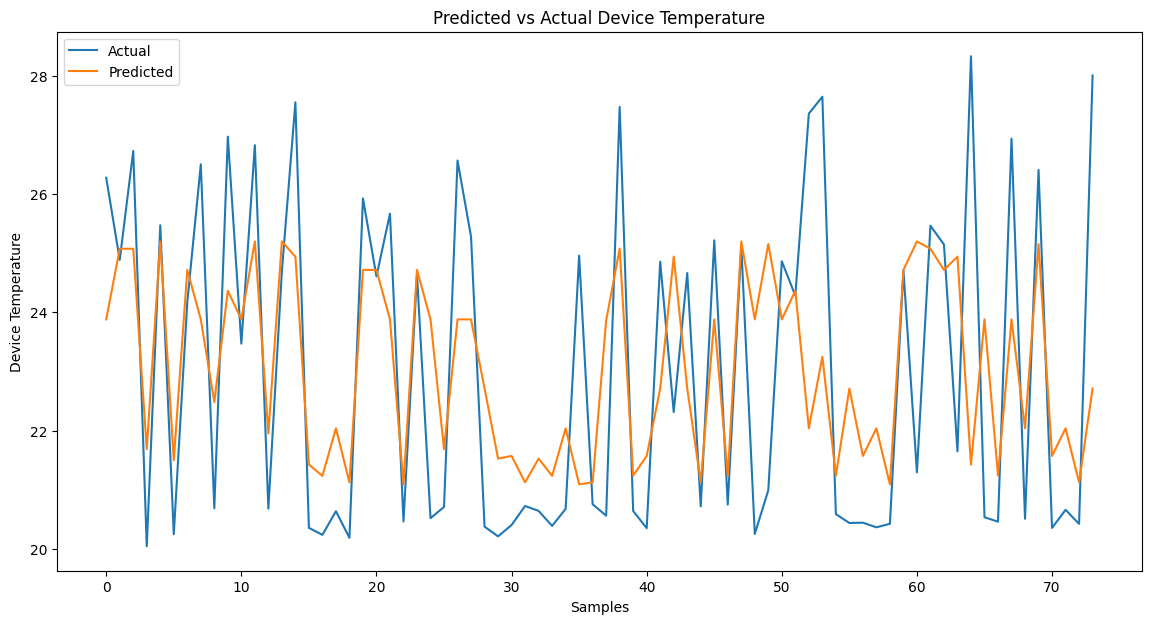

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt

# Load the resampled device data and climate data
device_data_resampled = pd.read_csv('dataset/transformed/may_device_resampled.csv')
climate_data = pd.read_csv('dataset/transformed/combined_weather_data.csv')

# Convert 'time' columns to datetime format
device_data_resampled['time'] = pd.to_datetime(device_data_resampled['time'])
climate_data['time'] = pd.to_datetime(climate_data['time'])

# Ensure the datetime format is consistent across both datasets
device_data_resampled['time'] = device_data_resampled['time'].dt.strftime('%Y-%m-%dT%H:%M:%S+08:00')
climate_data['time'] = climate_data['time'].dt.strftime('%Y-%m-%dT%H:%M:%S+08:00')

# Convert 'time' columns back to datetime format
device_data_resampled['time'] = pd.to_datetime(device_data_resampled['time'])
climate_data['time'] = pd.to_datetime(climate_data['time'])

# Merge datasets on the 'time' column
merged_data = pd.merge(climate_data, device_data_resampled, on='time', how='inner')

# Drop rows with missing target column values
target_column = 'device_temperature'
merged_data = merged_data.dropna(subset=[target_column])

# Define features and target variable
X = merged_data.drop(columns=[target_column, 'time'])
y = merged_data[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data into 3D shape for LSTM (samples, timesteps, features)
def reshape_for_lstm(data, timesteps=1):
    data_reshaped = data.reshape((data.shape[0], timesteps, data.shape[1]))
    return data_reshaped

timesteps = 1  # Set the number of timesteps as needed
X_train_lstm = reshape_for_lstm(X_train_scaled, timesteps)
X_test_lstm = reshape_for_lstm(X_test_scaled, timesteps)

# Define a function to create the LSTM model for hyperparameter tuning
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(timesteps, X_train_lstm.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Create the model
model = create_lstm_model()

# Train the model and store the training history
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Save the model and the scaler
model.save('my_lstm_model.h5')
joblib.dump(scaler, 'scaler.pkl')

# Evaluate the model
loss = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss}")

# Additional metrics
y_pred = model.predict(X_test_lstm)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Device Temperature')
plt.legend()
plt.title('Predicted vs Actual Device Temperature')
plt.show()


Epoch 1/100
10/10 [==============================] - 2s 44ms/step - loss: 551.7638 - mean_absolute_error: 23.3183 - val_loss: 534.2725 - val_mean_absolute_error: 22.9506
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 549.6625 - mean_absolute_error: 23.2741 - val_loss: 532.0174 - val_mean_absolute_error: 22.9027
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 547.0408 - mean_absolute_error: 23.2195 - val_loss: 529.1171 - val_mean_absolute_error: 22.8409
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 543.6921 - mean_absolute_error: 23.1486 - val_loss: 525.1119 - val_mean_absolute_error: 22.7555
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 538.8683 - mean_absolute_error: 23.0470 - val_loss: 519.4315 - val_mean_absolute_error: 22.6337
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 531.7134 - mean_absolute_error: 22.8955 - val_loss: 511.1074 - val_mean_absolute_

d:\Work\Capstone\Capstone-BMS-Project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 1.7078899947010686
Mean Squared Error (MSE): 4.875576951995728
Root Mean Squared Error (RMSE): 2.2080708666154103
R² Score: 0.35509693155462096


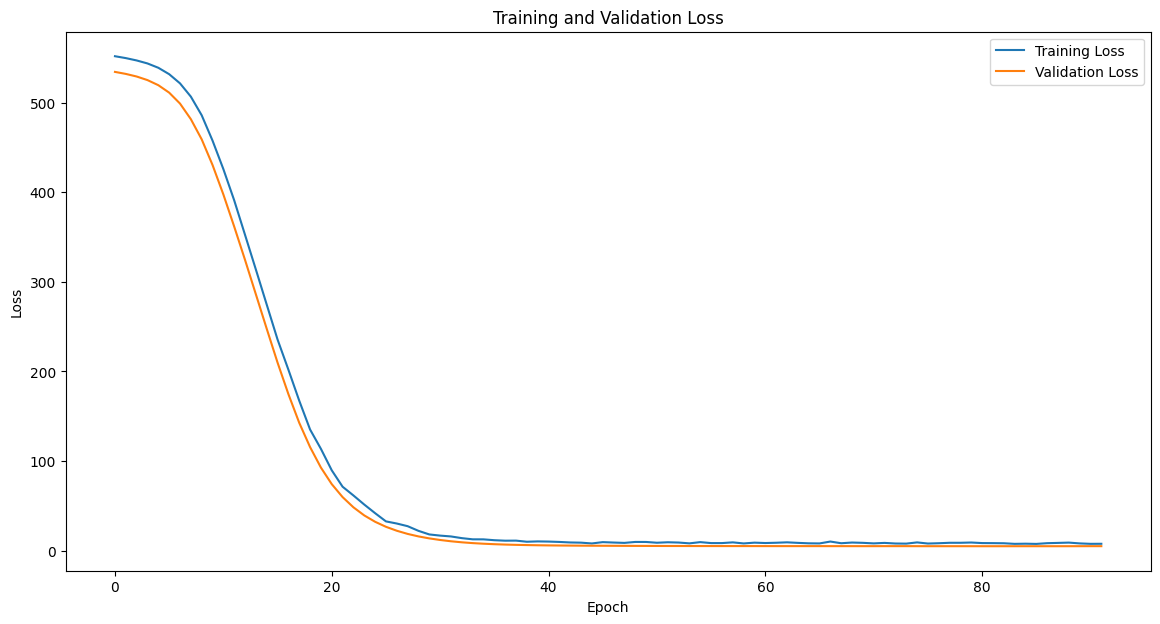

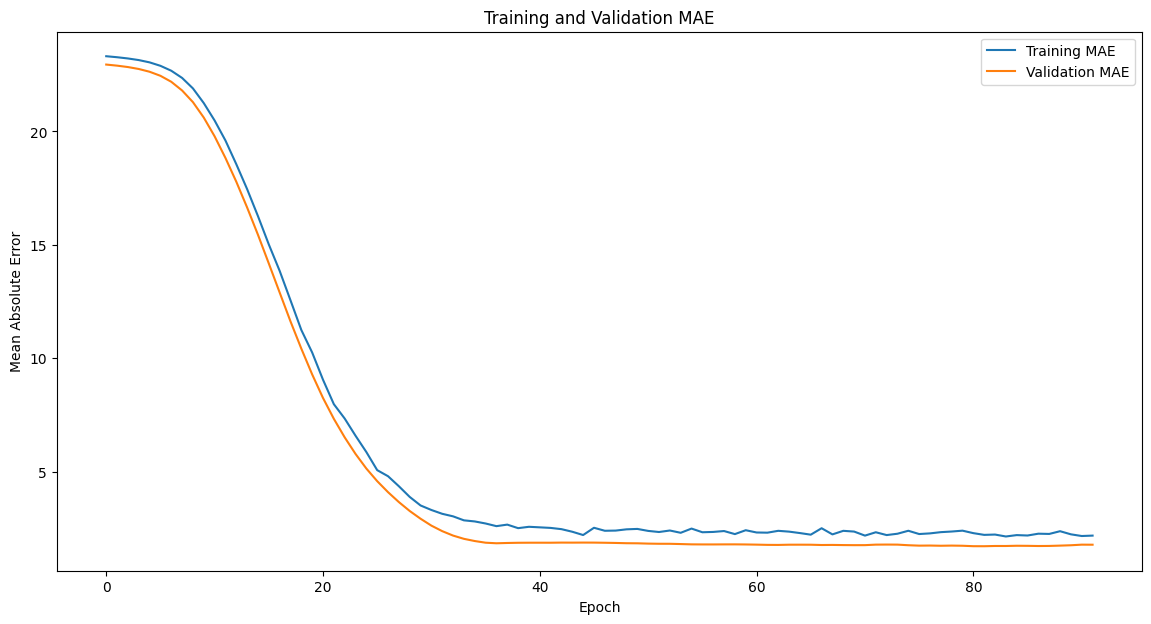

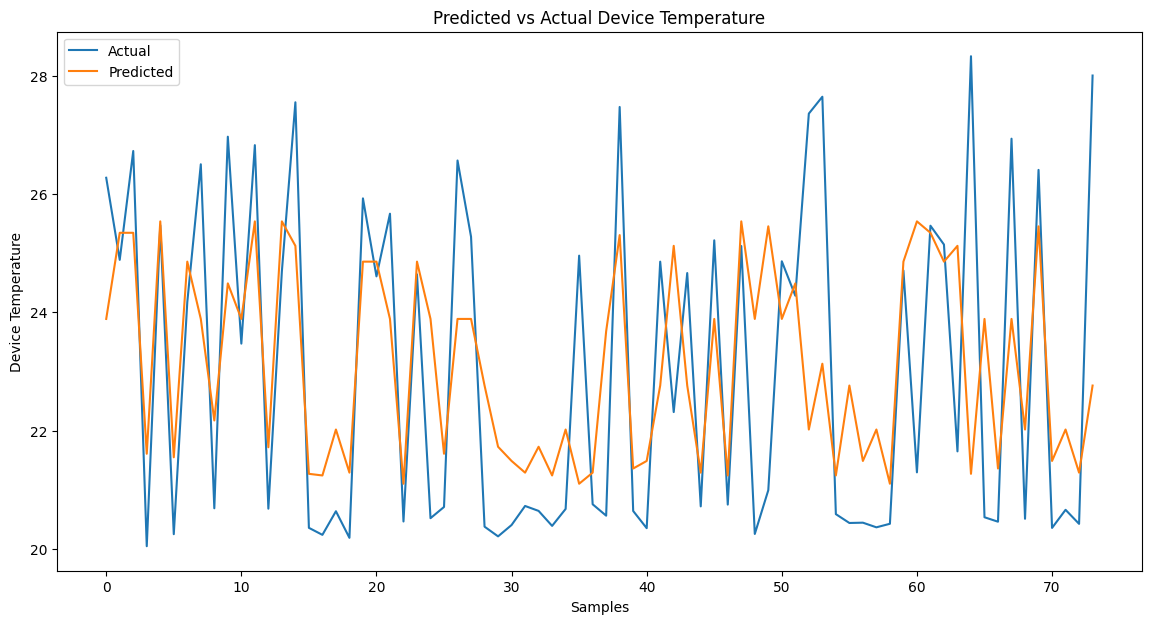

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt

# Load the resampled device data and climate data
device_data_resampled = pd.read_csv('dataset/transformed/may_device_resampled.csv')
climate_data = pd.read_csv('dataset/transformed/combined_weather_data.csv')

# Convert 'time' columns to datetime format
device_data_resampled['time'] = pd.to_datetime(device_data_resampled['time'])
climate_data['time'] = pd.to_datetime(climate_data['time'])

# Ensure the datetime format is consistent across both datasets
device_data_resampled['time'] = device_data_resampled['time'].dt.strftime('%Y-%m-%dT%H:%M:%S+08:00')
climate_data['time'] = climate_data['time'].dt.strftime('%Y-%m-%dT%H:%M:%S+08:00')

# Convert 'time' columns back to datetime format
device_data_resampled['time'] = pd.to_datetime(device_data_resampled['time'])
climate_data['time'] = pd.to_datetime(climate_data['time'])

# Merge datasets on the 'time' column
merged_data = pd.merge(climate_data, device_data_resampled, on='time', how='inner')

# Drop rows with missing target column values
target_column = 'device_temperature'
merged_data = merged_data.dropna(subset=[target_column])

# Define features and target variable
X = merged_data.drop(columns=[target_column, 'time'])
y = merged_data[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data into 3D shape for LSTM (samples, timesteps, features)
def reshape_for_lstm(data, timesteps=1):
    data_reshaped = data.reshape((data.shape[0], timesteps, data.shape[1]))
    return data_reshaped

timesteps = 1  # Set the number of timesteps as needed
X_train_lstm = reshape_for_lstm(X_train_scaled, timesteps)
X_test_lstm = reshape_for_lstm(X_test_scaled, timesteps)

# Define a function to create the LSTM model for hyperparameter tuning
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(timesteps, X_train_lstm.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Create the model
model = create_lstm_model()

# Train the model and store the training history
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Save the model and the scaler
model.save('my_lstm_model.h5')
joblib.dump(scaler, 'scaler.pkl')

# Evaluate the model
loss = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss}")

# Additional metrics
y_pred = model.predict(X_test_lstm)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(14, 7))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Device Temperature')
plt.legend()
plt.title('Predicted vs Actual Device Temperature')
plt.show()


3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 1.7078899947010686
R^2 Score: 0.35509693155462096


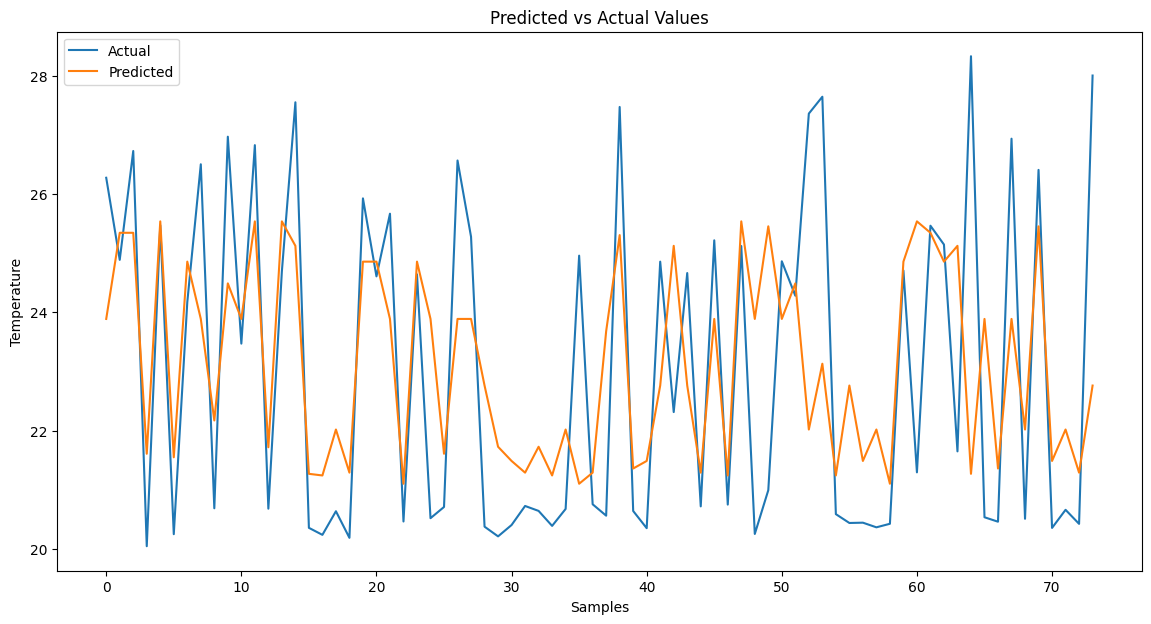

In [57]:
#EVALUATION CODE
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Temperature')
plt.legend()
plt.title('Predicted vs Actual Values')
plt.show()


Epoch 1/50
10/10 [==============================] - 2s 38ms/step - loss: 551.7178 - mean_absolute_error: 23.3188 - val_loss: 534.2780 - val_mean_absolute_error: 22.9526
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 549.5542 - mean_absolute_error: 23.2742 - val_loss: 531.9467 - val_mean_absolute_error: 22.9034
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 546.8093 - mean_absolute_error: 23.2168 - val_loss: 528.7394 - val_mean_absolute_error: 22.8361
Epoch 4/50
10/10 [==============================] - 0s 3ms/step - loss: 542.9116 - mean_absolute_error: 23.1362 - val_loss: 524.2567 - val_mean_absolute_error: 22.7414
Epoch 5/50
10/10 [==============================] - 0s 3ms/step - loss: 537.2896 - mean_absolute_error: 23.0186 - val_loss: 517.9101 - val_mean_absolute_error: 22.6064
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 529.4747 - mean_absolute_error: 22.8545 - val_loss: 508.3366 - val_mean_absolute_error:

d:\Work\Capstone\Capstone-BMS-Project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 1.8048619961372485
R^2 Score: 0.32202231518445645


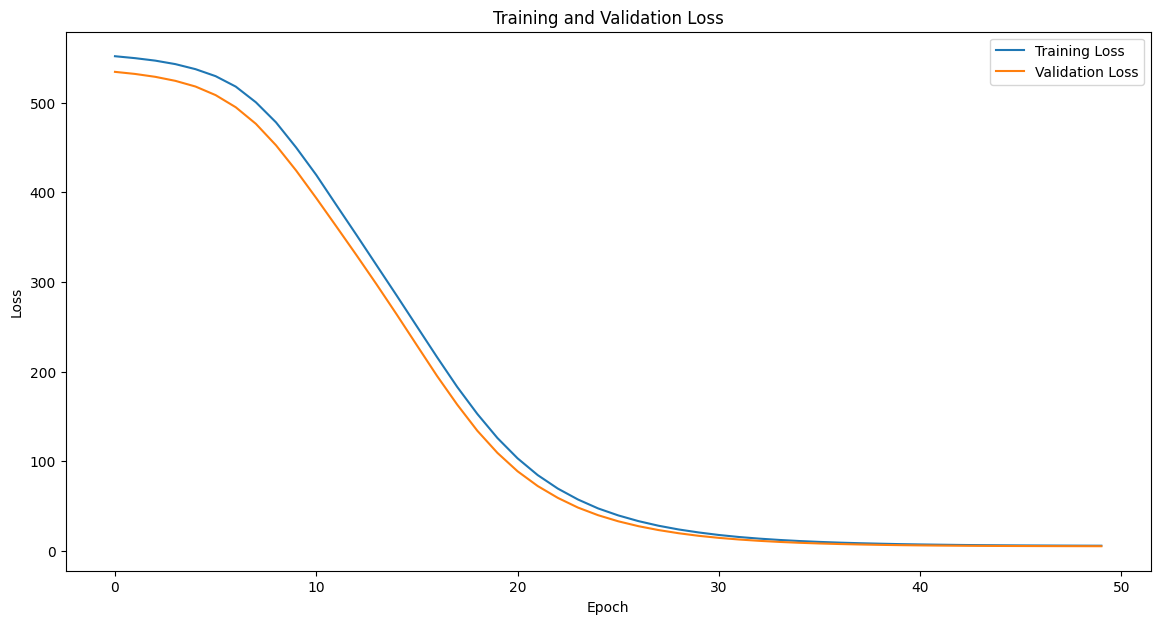

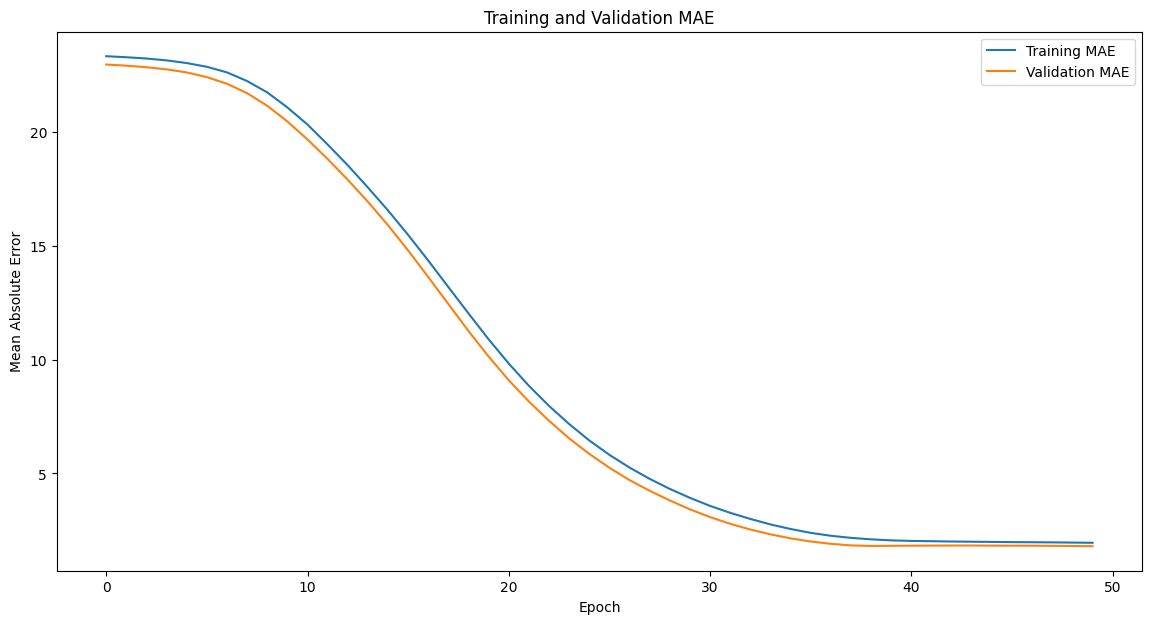

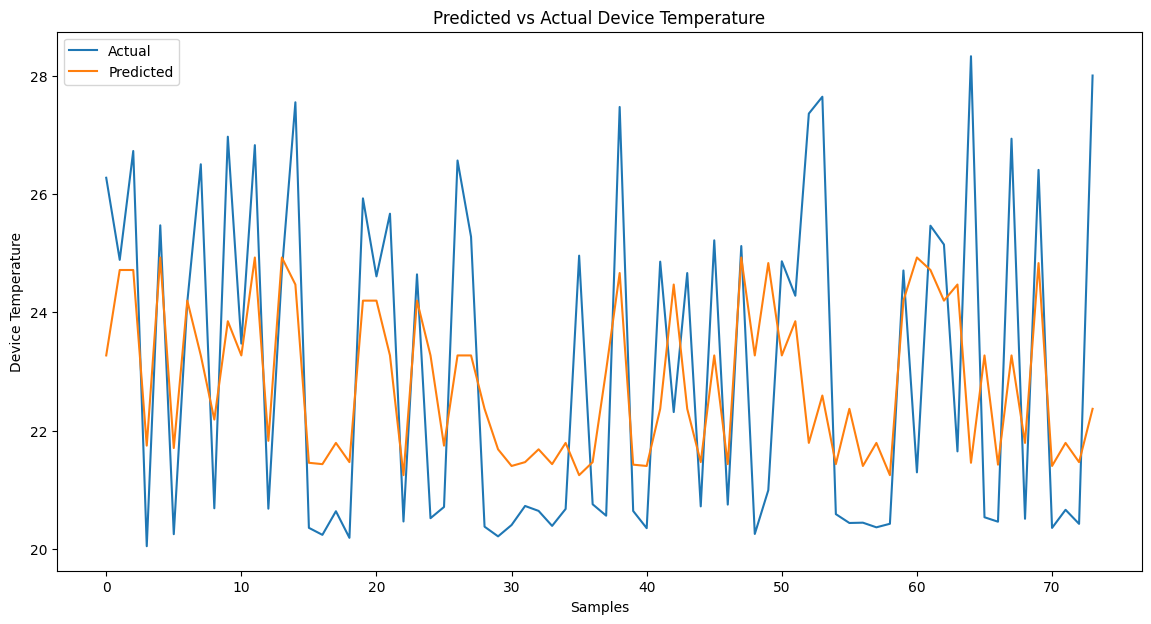

: 

In [58]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, X_train_lstm.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))  # Adjust the output layer based on the target variable

# Compile the model with MAE as an additional metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model and store the training history
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Save the model and the scaler
model.save('my_lstm_model.h5')
joblib.dump(scaler, 'scaler.pkl')

# Evaluate the model
loss = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss}")

# Additional metrics
y_pred = model.predict(X_test_lstm)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(14, 7))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Device Temperature')
plt.legend()
plt.title('Predicted vs Actual Device Temperature')
plt.show()
